# Motion Planning Part 1: motion planning as nonlinear least squares optimization

In this tutorial, we will learn how to implement the [GPMP2](https://journals.sagepub.com/doi/pdf/10.1177/0278364918790369) (Mukadam et al, 2018) motion planning algorithm, for a 2D robot in a planar environment.

The goal is to find the trajectory (pose and velocity) of the robot given a start and goal pose and some representation of the environment. This can be solved as an optimization problem where the variables to be optimized for are the 2D pose and 2D velocity of the robot along a trajectory of some total time steps (at some fixed time interval). In this example, we formulate the objective of the optimization with the following cost terms that are balanced by their respective weights:
* **Boundary condition**: the trajectory should begin at the start pose with zero velocity and end at the goal pose with zero velocity.
* **Collision avoidance**: the trajectory should avoid colliding with obstacles in the environment (we use a signed distance fields).
* **Smoothness**: the trajectory should be smooth (we use a zero acceleration prior).

In [1]:
import random

import matplotlib as mpl
import numpy as np
import torch
import torch.utils.data

import theseus as th
import theseus.utils.examples as theg

%load_ext autoreload
%autoreload 2

torch.set_default_dtype(torch.double)

device = "cuda:0" if torch.cuda.is_available else "cpu"
seed = 0
torch.random.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["font.size"] = 16

## 1. Loading and visualizing the trajectory data

First, let's load some motion planning problems from a dataset of maps and trajectories generated using the code in [dgpmp2](https://github.com/mhmukadam/dgpmp2).

In [2]:
dataset_dir = "data/motion_planning_2d"
dataset = theg.TrajectoryDataset(True, 2, dataset_dir, map_type="tarpit")
data_loader = torch.utils.data.DataLoader(dataset, 2)

batch = next(iter(data_loader))

The batch is a dictionary of strings to `torch.Tensor` containing the following keys:

In [3]:
for k, v in batch.items():
    if k != "file_id":
        print(f"{k:20s}: {v.shape}")

map_tensor          : torch.Size([2, 128, 128])
sdf_origin          : torch.Size([2, 2])
cell_size           : torch.Size([2, 1])
sdf_data            : torch.Size([2, 128, 128])
expert_trajectory   : torch.Size([2, 4, 101])


Let's plot the maps and trajectories loaded. `th.eb.SignedDistanceField2D` is a signed distance field object, which includes a function to convert *x,y*-coordinates to map cells that we use here for plotting. For completeness, we show the expert trajectories loaded, although we won't use them in this example (we will do so in Part 2 of this tutorial). We also illustrate the signed distance field for each map.

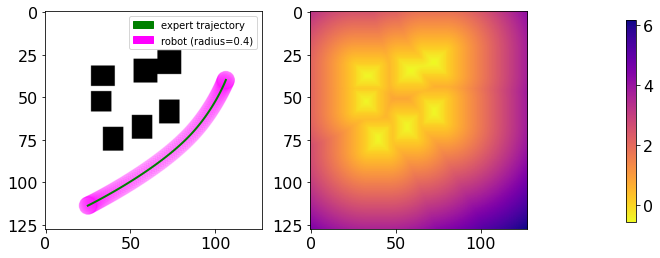

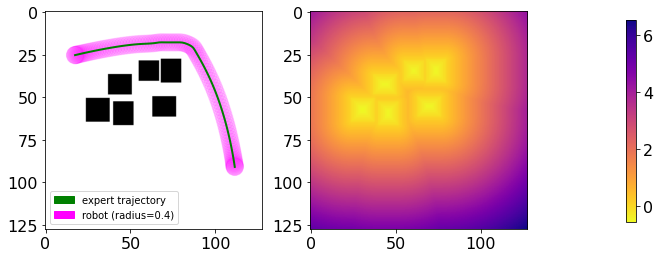

In [4]:
sdf = th.eb.SignedDistanceField2D(
    th.Point2(batch["sdf_origin"]),
    th.Variable(batch["cell_size"]),
    th.Variable(batch["sdf_data"]),
)
figs = theg.generate_trajectory_figs(
    batch["map_tensor"], 
    sdf, 
    [batch["expert_trajectory"]], 
    robot_radius=0.4, 
    labels=["expert trajectory"], 
    fig_idx_robot=0,
    figsize=(10, 4),
    plot_sdf=True,
)
figs[0].show()
figs[1].show()

The following are some constants that we will use throughout the example

In [5]:
trajectory_len = batch["expert_trajectory"].shape[2]
num_time_steps = trajectory_len - 1
map_size = batch["map_tensor"].shape[1]
safety_distance = 0.4
robot_radius = 0.4
total_time = 10.0
dt_val = total_time / num_time_steps
Qc_inv = [[1.0, 0.0], [0.0, 1.0]]
collision_w = 20.0
boundary_w = 100.0

## 2. Modeling the problem

### 2.1. Defining Variable objects

Our goal in this example will be to use `Theseus` to produce plans for the maps loaded above. As mentioned in the introduction, we need a 2D pose and a 2D velocity for each point along the trajectory to be optimized. For this, we will create a set of `th.Point2` variables with individual names, and store them in two lists so that they can be later passed to the appropriate cost functions.

In [6]:
# Create optimization variables
poses = []
velocities = []
for i in range(trajectory_len):
    poses.append(th.Point2(name=f"pose_{i}", dtype=torch.double))
    velocities.append(th.Point2(name=f"vel_{i}", dtype=torch.double))

In addition to the optimization variables, we will also need a set of *auxiliary* variables to wrap map-dependent quantities involved in cost function computation, but that are constant throughout the optimization. This includes start/goal target values, as well as parameters for collision and dynamics cost functions.

In [7]:
# Targets for pose boundary cost functions
start_point = th.Point2(name="start")
goal_point = th.Point2(name="goal")

# For collision avoidance cost function
sdf_origin = th.Point2(name="sdf_origin")
cell_size = th.Variable(torch.empty(1, 1), name="cell_size")
sdf_data = th.Variable(torch.empty(1, map_size, map_size), name="sdf_data")
cost_eps = th.Variable(torch.tensor(robot_radius + safety_distance).view(1, 1), name="cost_eps")

# For GP dynamics cost function
dt = th.Variable(torch.tensor(dt_val).view(1, 1), name="dt")

### 2.2. Cost weights

Next we will create a series of cost weights to use for each of the cost functions involved in our optimization problem.

In [8]:
# Cost weight to use for all GP-dynamics cost functions
gp_cost_weight = th.eb.GPCostWeight(torch.tensor(Qc_inv), dt)

# Cost weight to use for all collision-avoidance cost functions
collision_cost_weight = th.ScaleCostWeight(th.Variable(torch.tensor(collision_w)))

# For all hard-constraints (end points pos/vel) we use a single scalar weight
# with high value
boundary_cost_weight = th.ScaleCostWeight(boundary_w)

### 2.3. Cost functions

In this section, we will now create a `Theseus` objective and add the GPMP2 cost functions for motion planning. First, we create the objective:

In [9]:
objective = th.Objective(dtype=torch.double)

#### Boundary cost functions

Here we create cost functions for the boundary conditions, assign names to them, and add them to the `Objective`. For boundaries, we need four cost functions, and for each we use a cost function of type `th.Difference`. This cost function type takes as input an optimization variable, a cost weight, a target auxiliary variable, and a name. Its error function is the local difference between the optimization variable and the target.

For example, consider the first `Difference` added below (with name `pose_0`). This cost function will tell the optimizer to  try to bring the value of the variable at `poses[0]` close to that of auxiliary variable `start_point` (which is also a named variable, as explained in Section 2.1). On the other hand, for velocity constraints (for `vel_0`), we don't need to pass a *named* auxiliary variable for the target, since we know that we will want it to be a `torch.zeros(1, 2)`, no matter what the map data is (the robot start with zero velocity).

Finally, all of these cost functions share the same boundary_cost_weight, which as you may recall, is a `ScaleCostWeight(100.0)`.

In [10]:
# Fixed starting position
objective.add(
    th.Difference(poses[0], start_point, boundary_cost_weight, name="pose_0")
)
# Fixed initial velocity
objective.add(
    th.Difference(
        velocities[0],
        th.Point2(tensor=torch.zeros(1, 2)),
        boundary_cost_weight,
        name="vel_0",
    )
)
objective.add(
    th.Difference(
        poses[-1], goal_point, boundary_cost_weight, name="pose_N"
    )
)
objective.add(
    th.Difference(
        velocities[-1],
        th.Point2(tensor=torch.zeros(1, 2)),
        boundary_cost_weight,
        name="vel_N",
    )
)

#### Collision cost functions

For collision avoidance, we use a `th.eb.Collision2D` cost function type, which receives the following inputs:

* A single `th.Point2` optimization variable.
* Auxiliary variables:
    * Three representing signed distance field data (sdf_origin, sdf_data, cell_size).
    * The distance within which collision cost is incurred (cost_eps).
* A cost weight.
    
Since we need one such cost function for each internal point in the trajectory, we create the cost functions in a loop and pass the corresponding pose variable defined above. 

In [11]:
for i in range(1, trajectory_len - 1):
    objective.add(
        th.eb.Collision2D(
            poses[i],
            sdf_origin,
            sdf_data,
            cell_size,
            cost_eps,
            collision_cost_weight,
            name=f"collision_{i}",
        )
    )

#### GP-dynamics cost functions

For ensuring smooth trajectories, we use a `th.eb.GPMotionModel` cost function, which receives the following inputs:
 
* Four `th.Point2` optimization variables: pose at time t-1, velocity at time t-1, pose at time t, velocity at time t.
* One auxiliary variable describing the time differential between consecutive time steps.
* A cost weight (typically of type `th.eb.GPCostWeight`).

We need one such cost function for each pair of consecutive states (pose and velocity), so we add these in a loop and pass the appropriate optimization variables from the lists created above.

In [12]:
for i in range(1, trajectory_len):
    objective.add(
        (
            th.eb.GPMotionModel(
                poses[i - 1],
                velocities[i - 1],
                poses[i],
                velocities[i],
                dt,
                gp_cost_weight,
                name=f"gp_{i}",
            )
        )
    )

## Creating the TheseusLayer for motion planning

For this example, we will use Levenberg-Marquardt as the non-linear optimizer, coupled with a dense linear solver based on Cholesky decomposition.

In [13]:
optimizer = th.LevenbergMarquardt(
    objective,
    th.CholeskyDenseSolver,
    max_iterations=50,
    step_size=1.0,
)
motion_planner = th.TheseusLayer(optimizer)
motion_planner.to(device=device, dtype=torch.double)

## 3. Running the optimizer

Finally, we are ready to generate some optimal plans. We first initialize all auxiliary variables whose values are map dependent (e.g., start and goal positions, or SDF data). We also provide some sensible initial values for the optimization variables; in this example, we will initialize the optimizaton variables to be on a straight line from start to goal. The following helper function will be useful for this:

In [14]:
def get_straight_line_inputs(start, goal):
    # Returns a dictionary with pose and velocity variable names associated to a 
    # straight line trajectory between start and goal
    start_goal_dist = goal - start
    avg_vel = start_goal_dist / total_time
    unit_trajectory_len = start_goal_dist / (trajectory_len - 1)
    input_dict = {}
    for i in range(trajectory_len):
        input_dict[f"pose_{i}"] = start + unit_trajectory_len * i
        if i == 0 or i == trajectory_len - 1:
            input_dict[f"vel_{i}"] = torch.zeros_like(avg_vel)
        else:
            input_dict[f"vel_{i}"] = avg_vel
    return input_dict

Now, let's pass the motion planning data to our `TheseusLayer` and start create some trajectories; note that we can solve for both trajectories simultaneously by taking advantage of Theseus' batch support. For initializing variables, we create a dictionary mapping strings to `torch.Tensor`, where the keys are `th.Variable` names, and the values are the tensors that should be used for their initial values. 

In [15]:
start = batch["expert_trajectory"][:, :2, 0].to(device)
goal = batch["expert_trajectory"][:, :2, -1].to(device)
planner_inputs = {
    "sdf_origin": batch["sdf_origin"].to(device),
    "start": start.to(device),
    "goal": goal.to(device),
    "cell_size": batch["cell_size"].to(device),
    "sdf_data": batch["sdf_data"].to(device),
}
planner_inputs.update(get_straight_line_inputs(start, goal))    
with torch.no_grad():        
    final_values, info = motion_planner.forward(
        planner_inputs,
        optimizer_kwargs={
            "track_best_solution": True,
            "verbose": True,
            "damping": 0.1,
        }
    )

Nonlinear optimizer. Iteration: 0. Error: 3905.6714736579306
Nonlinear optimizer. Iteration: 1. Error: 2282.2513944732996
Nonlinear optimizer. Iteration: 2. Error: 136.22542880566306
Nonlinear optimizer. Iteration: 3. Error: 50.78312661081272
Nonlinear optimizer. Iteration: 4. Error: 4.300118887811325
Nonlinear optimizer. Iteration: 5. Error: 14.845572440720407
Nonlinear optimizer. Iteration: 6. Error: 2.369851877850203
Nonlinear optimizer. Iteration: 7. Error: 2.1764857434372713
Nonlinear optimizer. Iteration: 8. Error: 163.4663704087572
Nonlinear optimizer. Iteration: 9. Error: 2.213071348805167
Nonlinear optimizer. Iteration: 10. Error: 181.50298247224939
Nonlinear optimizer. Iteration: 11. Error: 2.2187748890964727
Nonlinear optimizer. Iteration: 12. Error: 169.89215894321373
Nonlinear optimizer. Iteration: 13. Error: 3.8054432326819017
Nonlinear optimizer. Iteration: 14. Error: 132.10105333886705
Nonlinear optimizer. Iteration: 15. Error: 1.8300133777058225
Nonlinear optimizer. It

## 4. Results

After the optimization is completed, we can query the optimization variables to obtain the final trajectory and visualize the result. The following function creates a trajectory tensor from the output dictionary of `TheseusLayer`.

In [16]:
def get_trajectory(values_dict):
    trajectory = torch.empty(values_dict[f"pose_0"].shape[0], 4, trajectory_len, device=device)
    for i in range(trajectory_len):
        trajectory[:, :2, i] = values_dict[f"pose_{i}"]
        trajectory[:, 2:, i] = values_dict[f"vel_{i}"]
    return trajectory

Let's now plot the final trajectories

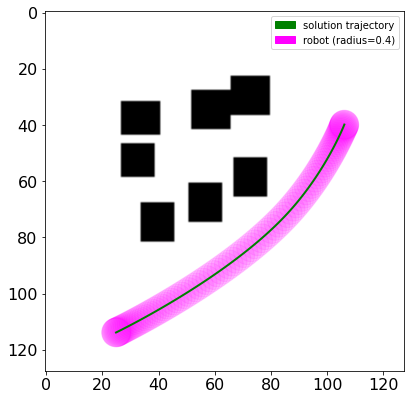

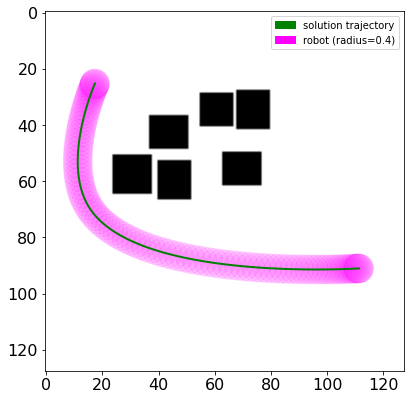

In [17]:
trajectory = get_trajectory(info.best_solution).cpu()

sdf = th.eb.SignedDistanceField2D(
    th.Point2(batch["sdf_origin"]),
    th.Variable(batch["cell_size"]),
    th.Variable(batch["sdf_data"]),
)
figs = theg.generate_trajectory_figs(
    batch["map_tensor"], 
    sdf, 
    [trajectory], 
    robot_radius=robot_radius, 
    labels=["solution trajectory"], 
    fig_idx_robot=0,
    figsize=(6, 6)
)
figs[0].show()
figs[1].show()